In [3]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN

In [4]:
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load a pretrained ResNet-50
resnet = models.resnet50(weights='IMAGENET1K_V1')
resnet.eval()

import timm
vit = timm.create_model('vit_base_patch16_224', pretrained=True)
vit.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### First image

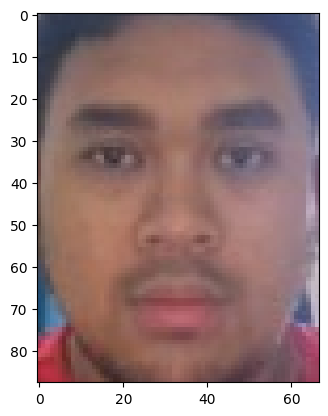

In [6]:
image = Image.open('hasnan_2.jpg')

# Detect faces
boxes, _ = mtcnn.detect(image)

# Draw bounding boxes and extract faces
fig, ax = plt.subplots()
ax.imshow(image)
for box in boxes:
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red')
    ax.add_patch(rect)

    # Crop face
    face = image.crop(box)
    plt.imshow(face)
    plt.show()

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

face_tensor = transform(face).unsqueeze(0)

In [8]:
with torch.no_grad():
    resnet_features = resnet(face_tensor)
    vit_features = vit(face_tensor)

### Second image 

In [9]:
# Load the comparison image
image2 = Image.open('rama.jpg')

# Detect face in the second image
boxes2, _ = mtcnn.detect(image2)

# Assume we take the first detected face
face2 = image2.crop(boxes2[0])

# Transform the face image
face2_tensor = transform(face2).unsqueeze(0)  # Add batch dimension


In [10]:
with torch.no_grad():
    resnet_features2 = resnet(face2_tensor)
    vit_features2 = vit(face2_tensor)

In [11]:
from scipy.spatial.distance import cosine

# Calculate cosine similarity between ResNet features
similarity_resnet = 1 - cosine(resnet_features.flatten(), resnet_features2.flatten())

# Calculate cosine similarity between ViT features
similarity_vit = 1 - cosine(vit_features.flatten(), vit_features2.flatten())

print(f"Cosine similarity using ResNet: {similarity_resnet}")
print(f"Cosine similarity using ViT: {similarity_vit}")

Cosine similarity using ResNet: 0.7534234628960255
Cosine similarity using ViT: 0.7828350609417452


In [13]:
threshold = 0.7  # This threshold should be fine-tuned based on your specific dataset and requirements

if similarity_resnet > threshold:
    print("Faces matched using ResNet features.")
else:
    print("Faces did not match using ResNet features.")

if similarity_vit > threshold:
    print("Faces matched using ViT features.")
else:
    print("Faces did not match using ViT features.")

Faces matched using ResNet features.
Faces matched using ViT features.
